## Zadanie - klasyczna detekcja obiektów

Celem tego zadania jest własnoręczne zbudowanie, debugowanie i przetestowanie przez Ciebie prostego pipeline'u do rozpoznawania obiektów opartego o klasyczne metody przetwarzania obrazów.

In [106]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List

Dany jest obraz wzorcowy `calib` przedstawiający leki w organizerze.
Twoim zadaniem będzie zaproponowanie algorytmu detekcji, który przyjmie obraz wejściowy i wykryje na nim obiekty - poszczególne tabletki, zwracając informację o ich położeniach i gatunkach.
Reprezentacja tej informacji jest dowolna: pary koordynat (X,Y) środka obiektu, bounding boksy (XYHW), czy kontury - istotne jest jedynie, by liczba detekcji możliwie dobrze zgadzała się ze stanem faktycznym.

Zadanie ma charakter projektowy i nie jest podzielone na szczegółowo opisane podpunkty, ponieważ można do niego podejść na różne sposoby (czytaj dalej).

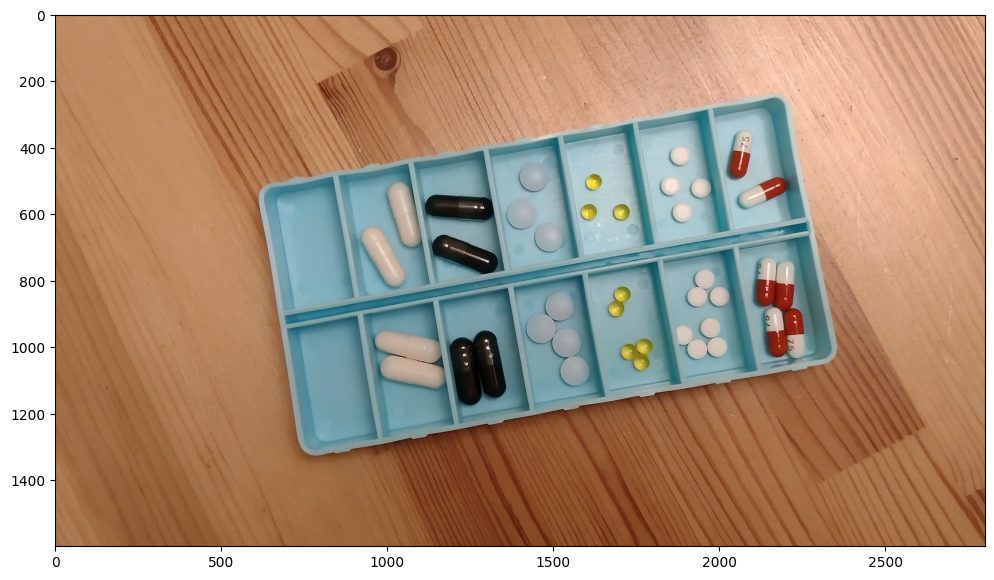

In [107]:
calib = cv2.imread('dane/calib.png')
plt.subplots(1, 1, figsize=(12,8))[1].imshow(calib[..., ::-1]);

Występuje 6 klas obiektów; patrząc na organizer od lewej:

In [108]:
class PillType(Enum):
    PROBIO = 1    # duże białe kapsułki
    CARBON = 2    # duże czarne kapsułki
    KETO = 3      # niebieskie tabletki
    ESPU = 4      # małe żółte kapsułki
    BIOX = 5      # małe białe tabletki
    LINE = 6      # czerwono-białe kapsułki (klasa trudna - realizacja opcjonalna)

Górny rząd zawiera łatwiejsze przykłady pojedynczych instancji, podczas gdy w rzędzie dolnym obiekty stykają się ze sobą, co utrudnia identyfikację.
Jak widzisz, nie wszystkie klasy są tak samo "wdzięczne" do wykrycia.
Nie próbuj zatem robić wszystkiego naraz - rekomendowane jest podejście sekwencyjne: najpierw zaimplementuj algorytm detekcji dla jednej klasy, przetestuj go i napraw, rozszerz o możliwość detekcji stykających się obiektów (_jak to zrobić?_), a dopiero potem podejmij kolejną klasę.

Wykorzystaj narzędzia poznane do tej pory (konwersje przestrzeni barw, binaryzację, detekcję krawędzi, etc.) by sprowadzić obraz do takiej postaci, w której detekcję interesujących obiektów będzie można wykonać za pomocą zwyczajnej ekstrakcji komponentów spójności - [`cv2.findContours`](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0).
Wspomóż się operacjami morfologicznymi jeśli to potrzebne, i nie wahaj się stosować jakichkolwiek narzędzi jakie znajdziesz -
wszystkie chwyty są dozwolone, za wyjątkiem stosowania metod MLowych.

W zależności od wybranej reprezentacji wykrytych obiektów, zaimplementuj metodę wizualizacji wyników.

Nie usuwaj notebooka, w którym będziesz debugować algorytm!
Przyda się podczas rozmowy, jeśli zajdzie konieczność wyjaśnienia dlaczego twój algorytm popełnia błędy - możliwość pokazania krok po kroku wykonywanych operacji będzie istotna.

### Rozwiązanie:

In [109]:
class Pill:
    """Output of object detection, represents a single instance"""
    def __init__(self, pill_type: PillType, location: Any):
        self.type = pill_type
        self.location = location

In [110]:
def detect_carbon_pills(image: np.ndarray, image_hsv: np.ndarray) -> tuple[list[Pill], np.ndarray]:
    """Detects carbon (black) pills in the image"""

    thresholded = cv2.threshold(image, 40, 255, cv2.THRESH_BINARY_INV)[1]

    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c for c in contours if c.shape[0] > 200]
    hull_mask = np.zeros_like(image)
    for contour in contours:
        hull = cv2.convexHull(contour)
        cv2.drawContours(hull_mask, [hull], -1, 255, thickness=cv2.FILLED)

    contours = cv2.findContours(hull_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    sizes = [cv2.contourArea(c) for c in contours]
    pills = []
    
    if all(s < 20000 for s in sizes):
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            x1, y1, w1, h1 = x, y, x+w, y+h
            pills.append(Pill(PillType.CARBON, (x1, y1, w1, h1)))
            
        return pills, hull_mask
    
    h,s,v = cv2.split(image_hsv)
    mask_h = cv2.inRange(h, 8, 19)
    kernel = np.ones((9, 9), np.uint8)
    mask_h = cv2.morphologyEx(mask_h, cv2.MORPH_CLOSE, kernel)
    
    mask = cv2.bitwise_and(hull_mask, mask_h)
    mask = cv2.dilate(mask, (5,5), iterations=10)
    contours = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, y1, w1, h1 = x-int(w/4), y-int(h/4), x+w+int(w/4), y+h+int(h/4)
        pills.append(Pill(PillType.CARBON, (x1, y1, w1, h1)))

    return pills, hull_mask


In [111]:
def detect_espu_pills(image: np.ndarray) -> List[Pill]:
    """Detects espu (yellow) pills in the image"""   
    y,u,v = cv2.split(image)
    thresholded = cv2.threshold(u, 80, 255, cv2.THRESH_BINARY_INV)[1]
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pills = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, y1, w1, h1 = x-int(w/2), y-int(h/2), x+w+int(w/2), y+h+int(h/2)
        pills.append(Pill(PillType.ESPU, (x1, y1, w1, h1)))
    return pills

In [112]:
def detect_keto_pills(image: np.ndarray) -> List[Pill]:
    """Detects keto (blue) pills in the image"""
    h,l,s = cv2.split(image)
    thresholded = cv2.threshold(s, 35, 255, cv2.THRESH_BINARY_INV)[1]
    eroded = cv2.erode(thresholded, np.ones((5,5), np.uint8), iterations=8)
    dilated = cv2.dilate(eroded, np.ones((5,5), np.uint8), iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    pills = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x1, y1, w1, h1 = x-int(w/2), y-int(h/2), x+w+int(w/2), y+h+int(h/2)
        pills.append(Pill(PillType.KETO, (x1, y1, w1, h1)))
    return pills

In [113]:
def detect_probio_pills(image_hsv: np.ndarray, image_yuv: np.ndarray, image_lab: np.ndarray) -> List[Pill]:
    """Detects probio (big white) pills in the image"""
    h,s,v = cv2.split(image_hsv)
    y,u,v = cv2.split(image_yuv)
    l,a,b = cv2.split(image_lab)
    mask_h = cv2.inRange(h, 9, 25)

    mask_u = cv2.inRange(u, 115, 120)

    mask_hu = cv2.bitwise_and(mask_h, mask_u)
    mask_b = ~cv2.inRange(b, 145, 170)
    mask_hub = cv2.bitwise_and(mask_hu, mask_b)
    eroded = cv2.erode(mask_hub, np.ones((3,3), np.uint8), iterations=9)
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    white_pills = [c for c in contours if cv2.contourArea(c) > 1000]
    
    pills = []
    for c in white_pills:
        x, y, w, h = cv2.boundingRect(c)
        x1, y1, w1, h1 = x-int(w/3), y-int(h/3), x+w+int(w/3), y+h+int(h/3)
        # x1, y1, w1, h1 = x, y, x+w, y+h
        pills.append(Pill(PillType.PROBIO, (x1, y1, w1, h1)))
    return (pills, white_pills)

In [114]:
def detect_biox_pills(image: np.ndarray, image_hsv: np.ndarray, black_hull_mask: np.ndarray, white_pills: np.ndarray) -> tuple[list[Pill], np.ndarray]:
    """Detects biox (small white) pills in the image"""
    # l,a,b = cv2.split(image_lab)
    # mask_b = cv2.inRange(b, 130, 140)
    # edored = cv2.erode(mask_b, np.ones((3,3), np.uint8), iterations=2)
    # circles = cv2.HoughCircles(edored, method = cv2.HOUGH_GRADIENT, dp = 1, minDist=30, param1=200, param2=12,minRadius=20, maxRadius=40)
    # pills = []
    # if circles is not None:
    #         circles = np.uint16(np.around(circles))
    #         for i in circles[0, :]:
    #             x, y = i[0], i[1]
    #             radius1 = i[2]
    #             # print(center1, radius1)
    #             x, y, w, h = x-radius1-int(radius1/2), y-radius1-int(radius1/2), x+int(1.5*radius1), y+int(1.5*radius1)
    #             # cv2.rectangle(image, (x-radius1-int(radius1/2), y-radius1-int(radius1/2)), (x+int(1.5*radius1), y+int(1.5*radius1)), 255, 3)
    #             pills.append(Pill(PillType.BIOX, (x, y, w, h)))
    # return pills
    h,s,v = cv2.split(image_hsv)
    blue_mask = cv2.inRange(h, 80, 130)
    # plt.imshow(blue_mask, cmap='gray');

    contours = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    # plt.imshow(cv2.drawContours(np.zeros_like(b), contours, -1, 255, 3));
    hull_mask = np.zeros_like(blue_mask)
    for contour in contours:
        # Get the convex hull of the contour
        hull = cv2.convexHull(contour)
        # Draw and fill the convex hull
        cv2.drawContours(hull_mask, [hull], -1, 255, thickness=cv2.FILLED)
    hull_mask = ~hull_mask
    # plt.imshow(hull_mask, cmap='gray');
    pills_mask = ~cv2.bitwise_or(blue_mask, hull_mask)
    pills_mask = cv2.erode(pills_mask, np.ones((5,5), np.uint8), iterations=3)
    pills_mask = cv2.dilate(pills_mask, np.ones((3,3), np.uint8), iterations=5)

    pills = cv2.bitwise_and(image, image, mask=pills_mask)
    white_only = cv2.bitwise_and(~black_hull_mask, pills_mask)

    y,u,v = cv2.split(cv2.cvtColor(pills, cv2.COLOR_BGR2YUV))
    mask_u = cv2.inRange(u, 100, 255)
    # mask_red = cv2.inRange(h, 0, 5)
    white_only = cv2.bitwise_and(white_only, mask_u)

    hull_mask = np.zeros_like(white_only)
    for contour in white_pills:
        # Get the convex hull of the contour
        hull = cv2.convexHull(contour)
        # Draw and fill the convex hull
        cv2.drawContours(hull_mask, [hull], -1, 255, thickness=cv2.FILLED)

    hull_mask = cv2.dilate(hull_mask, np.ones((5,5), np.uint8), iterations=7)
    hull_mask = ~hull_mask

    white_only = cv2.bitwise_and(white_only, hull_mask)
    eroded_white = cv2.erode(white_only, np.ones((3,3), np.uint8), iterations=10)
    contours = cv2.findContours(eroded_white, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    small = [c for c in contours if cv2.contourArea(c) < 1000]
    small = [c for c in small if cv2.contourArea(c) > 200]

    pills = []
    for c in small:
        x, y, w, h = cv2.boundingRect(c)
        x1, y1, w1, h1 = x-int(w/2), y-int(h/2), x+w+int(w/2), y+h+int(h/2)
        # cv2.rectangle(image, (x-int(w/2), y-int(h/2)), (x+w+int(w/2), y+h+int(h/2)), (255, 255, 0), 3)
        pills.append(Pill(PillType.BIOX, (x1, y1, w1, h1)))
    return pills


In [115]:
def detect_objects(image: np.ndarray, **kwargs) -> List[Pill]:
    """Detects objects in the image"""
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image_hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    pills = []
    # print(pills)
    carb, black_hull_mask = detect_carbon_pills(image_gray, image_hsv)
    pills.extend(carb)
    pills.extend(detect_espu_pills(image_yuv))
    pills.extend(detect_keto_pills(image_hls))
    probio, white_pills = detect_probio_pills(image_hsv, image_yuv, image_lab)
    pills.extend(probio)
    pills.extend(detect_biox_pills(image, image_hsv, black_hull_mask, white_pills))
    return pills
    # TU BĘDZIE TWOJA IMPLEMENTACJA DETEKTORA
    # raise NotImplementedError

In [116]:
COLORMAP = {
    # RGB colorspace
    PillType.PROBIO: (255, 255, 255),
    PillType.CARBON: (0, 0, 0),
    PillType.KETO: (0, 0, 255),
    PillType.ESPU: (255, 255, 0),
    PillType.BIOX: (255, 0, 255),
    PillType.LINE: (255, 0, 0),
}

def display_objects(image: np.ndarray, objects: List[Pill]) -> None:
    # TU BĘDZIE TWOJA IMPLEMENTACJA METODY WIZUALIZACJI
    image = image.copy()
    for obj in objects:
        color = COLORMAP[obj.type]
        x, y, w, h = obj.location
        cv2.rectangle(image, (x, y), (w, h), color, 4)

    plt.figure(figsize=(12, 8))
    plt.imshow(image[..., ::-1])

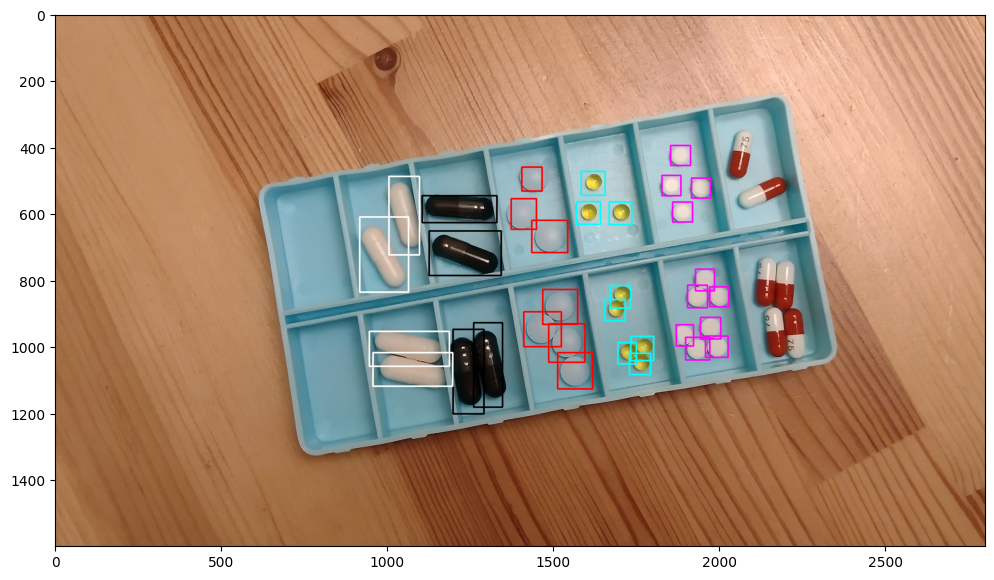

In [117]:
found = detect_objects(calib)
display_objects(calib, found)

### Test

Przetestuj swój algorytm na obrazie testowym `test.png` (lub `test_line.png`, jeśli podejmujesz się detekcji klasy LINE).
Gdzie pojawiają się problemy, skąd się biorą?
Jak można im zaradzić?

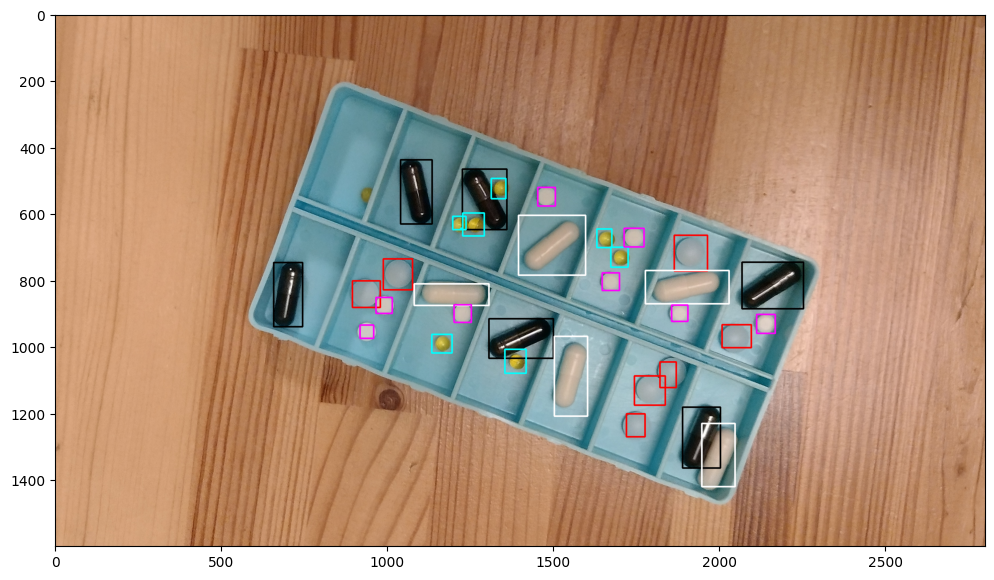

In [118]:
test = cv2.imread('dane/test.png')
found = detect_objects(test)
display_objects(test, found)

---

### Zadanie dodatkowe - dla chętnych

Cel: zliczenie wystąpień leków w poszczególnych komórkach organizera.

Wykorzystaj transformację Hougha do wykrycia linii oddzielających komórki organizera.
Dowolną poznaną metodą oblicz środki wykrytych obiektów.
Połącz obie informacje by określić zawartość każdej z komórek.

Wynik tej operacji powinien mieć formę struktury logicznej, pozwalającej na odpowiadanie na pytania np. "czy w 3 komórce dolnego rzędu są dwie sztuki `biox`?";
żadne szczegóły implementacyjne tej struktury nie są narzucone.

Jak poprzednio, zacznij od obrazu `calib`, a gotowy algorytm przetestuj na obrazach testowych.